# Before running this file for the first time...
* Go to the Anaconda Navigator and click on CMD.exe Prompt. 
* A command line terminal will open. Type in conda install -c conda-forge shapely
* Press Enter.
* When asked to proceed, type y and press Enter.
* Then you can run this file. (You only need to do this once!)

In [5]:
# Import from libraries.
from numpy import array, dot, empty, zeros, max, linspace, meshgrid # Import any other math functions you need here.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

from shapely.geometry import Point, Polygon, LineString

corners = [(1,1),(-1,1),(-1,-1),(1,-1)]
shape = Polygon(corners)

# Let's try out the "within" function.
p1 = Point(0.9,0.5)
print(p1.within(shape)) # Tells us whether p1 is inside the bounds of shape.
pbox = Polygon([(-1.1,0.6),(-1.1,0.7),(-0.9,0.7),(-0.9,0.6)])
print(pbox.overlaps(shape))

True
True


In [6]:
# Define polarization.

def polarization(x,y):
    p = Point((x,y))
    if (p.within(shape)):
        px = 0 # Change this to match your polarization's x-component.
        py = 1 # Change this to match your polarization's y-component.
    else:
        px = 0
        py = 0
    return array([px,py])

In [7]:
# Set constants.
M = 100 # Number of grid squares on a side.
Vtop = 0.0 # Voltage at top boundary.
Vbottom = 0.0 # Voltage at bottom boundary.
Vleft = 0.0 # Voltage at left boundary.
Vright = 0.0 # Voltage at right boundary.

xmin = -2 # Starting value of x & y.
xmax = 2 # Ending value of x & y.
dx = (xmax-xmin)/M # Step size. Don't need to change.

# Create arrays to hold potential values and points.
phi = zeros([M+1,M+1],float) # Current guess for potential.
phiprime = empty([M+1,M+1],float) # Next guess for potential.
xlist = linspace(xmin,xmax,M+1) # List of x-coordinates.
ylist = linspace(xmin,xmax,M+1) # List of y-coordinates.
# print(xlist)

# Calculate rho_b = -divergence(polarization) and sigma_b = polarization dot nhat along border.
rho_b = zeros((len(xlist),len(ylist)))
for i in range(1,len(xlist)-1):
    for j in range(1,len(ylist)-1):
        x = xlist[i]
        y = ylist[j]
        p = Point(x,y)
        posn = array([x,y])
        pbox = Polygon([(x+dx/2,y+dx/2),(x-dx/2,y+dx/2),(x-dx/2,y-dx/2),(x+dx/2,y-dx/2)])
        if (p.within(shape)):
#             print(x,y,"within")
            xr = xlist[i+1]
            xl = xlist[i-1]
            ya = ylist[j+1]
            yb = ylist[j-1]
            dPx = polarization(xr,y)[0] - polarization(xl,y)[0]
            dPy = polarization(x,ya)[1] - polarization(x,yb)[1]
            rho_b[i][j] = -(dPx+dPy)/(2*dx)
        elif (pbox.overlaps(shape)):
#             print(x,y,"overlap")
            # See if we're on an edge.
            nhat = array([0,0])
            for k in range(len(shape.exterior.coords)-1):
                edge = LineString([shape.exterior.coords[k],shape.exterior.coords[k+1]])
                if (not pbox.disjoint(edge)):
                    nhat = array([shape.exterior.coords[k+1][1]-shape.exterior.coords[k][1],shape.exterior.coords[k][0]-shape.exterior.coords[k+1][0]])
            rho_b[i][j] = dot(polarization(x,y),nhat)/dx
#             print(rho_b[i][j])
#         else:
#             print(x,y,"nothing")
#         
# print(rho_b)
print("finished.")

finished.


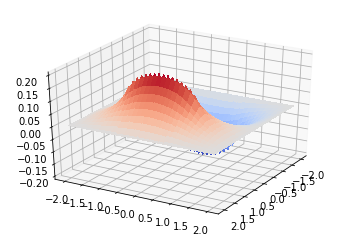

In [11]:
# Set constant boundary conditions.
# Left edge, where i = 0 is fixed.
phi[0,:] = Vleft
# Right edge, where i = M is fixed.
phi[M,:] = Vright
# Bottom edge, where j = 0 is fixed.
phi[:,0] = Vbottom
# Top edge, where j = M is fixed.
phi[:,M] = Vtop

# If you need to set up a funciton along one of the edges,
# follow this example. It sets up V(x,0) = xmax*x-x**2 along 
# the bottom edge. This is just a function picked for demonstration.
# Use phi[i,0] for the bottom edge, phi[i,M] for the top edge,
# phi[0,j] for the left edge, and phi[M,j] for the right edge.
# for i in range(0,M+1):
#     phi[i,0] = (xmax*xlist[i]-xlist[i]**2)*4/xmax**2

target = 1e-5 # Target accuracy, scaled by problem.

# Main loop
delta = 1.0 # Current error between phi and phiprime.
while delta > target: # Repeat until error is lower than target accuracy.
    # Calculate new values of the potential.
    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M: # Endpoitns stay fixed.
                phiprime[i,j] = phi[i,j]
            else:
                # Calculate next guess based on difference equation.
                phiprime[i,j] = (phi[i+1,j]+phi[i-1,j]+phi[i,j+1]+phi[i,j-1])/4 + dx**2/4*rho_b[i,j]
    # Calculate maximum difference from old values.
    delta = max(abs(phi-phiprime))
    # Swap the two arrays.
    phi,phiprime = phiprime,phi

# Turn lists into a format that matplotlib wants.
X, Y = meshgrid(xlist, ylist)

# Set viewing angle for graph.
angle = 30

# Create figure and plot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, phi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(30, angle)
plt.draw()

# Need a different view? Change new_angle (in degrees) in the next cell and run it. 
# Then you can regraph your results without having to re-run the computation.

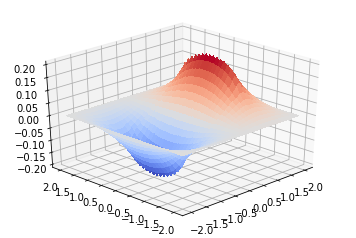

In [12]:
# Set new angle, in degrees.
new_angle = 45+180

# Create new figure and plot.
new_fig = plt.figure()
new_ax = new_fig.add_subplot(111, projection='3d')
new_surf = new_ax.plot_surface(X, Y, phi, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
new_ax.view_init(30, new_angle)
plt.draw()

In [13]:
# Calculate electric field from the potential's gradient.

from numpy import gradient

efield = gradient(-phi,dx)

# efield has two lists: The x-components of the electric field,
# and the y-components of the electric field. 
# It stores this information like so:
# efield[k][i][j] is the kth-component (k = 0 means x, k = 1 means y)
# of E at the point(xlist[i],ylist[j])

# Find maximum electric field magnitude to scale arrows later.
emax = 0.0
for k in range(2):
    for i in range(len(xlist)):
        for j in range(len(ylist)):
            if (emax<abs(efield[k][i][j])):
                emax = abs(efield[k][i][j])


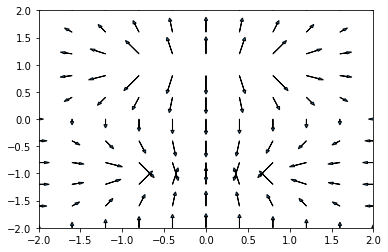

In [14]:
# Graph the electric field.

# Set visual scale factors. Adjust as necessary to make e-field visible.
arrow_length_scale_factor = 10 # Increase to make arrows longer.
arrow_head_scale_factor = 1 # Increase to make arrowheads larger.
arrow_skip = 10 # Increase to show fewer arrows.

escale = dx/emax*arrow_length_scale_factor
e_fig = plt.figure()
e_ax = e_fig.add_subplot()
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
for i in range(0,len(xlist),arrow_skip):
    for j in range(0,len(ylist),arrow_skip):
        plt.arrow(xlist[i],ylist[j],efield[0][i][j]*escale,efield[1][i][j]*escale,head_width=dx*arrow_head_scale_factor)

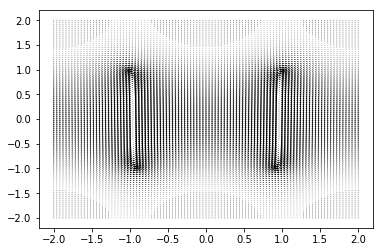

In [15]:
# Here's another way to create this graph using the quiver plotting function.
# It makes the arrows more crowded but helps show how the field changes.

plt.quiver(X,Y,efield[0],efield[1])


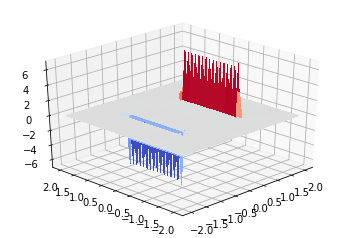

In [16]:
# Calculate the divergence of E. This SHOULD give us back rho(x,y).
divergence = zeros((len(xlist),len(ylist)))
for i in range(1,len(xlist)-1):
    for j in range(1,len(ylist)-1):
        dEx = efield[0][i+1][j]-efield[0][i-1][j]
        dEy = efield[1][i][j+1]-efield[1][i][j-1]
        divergence[i][j] = (dEx+dEy)/(2*dx)
# Create new figure and plot divergence.
div_fig = plt.figure()
div_ax = div_fig.add_subplot(111, projection='3d')
div_surf = div_ax.plot_surface(X, Y, divergence, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
div_ax.view_init(30, new_angle)
plt.draw()

# Little bit of error at the corners, but that's to be expected!
# Copy, paste, and modify this cell to show the curl at each point.
# Copy, paste, and modify this cell to show the flux at each point.

In [17]:
# Calculate the total charge distribution. 
# This SHOULD be zero for a polarized object with no external field.

total = 0
for i in range(len(xlist)):
    for j in range(len(ylist)):
        total += rho_b[i][j]
print(total)

0.0
